Q_in = 0.0150 m3/s, Q_r = 0.0030 m3/s, Q_e = 0.0120 m3/s
dz = 0.080 m
v_bulk min = -5.57e-05 m/s, max = 2.23e-04 m/s
dt = 9.29 s
Nt = 776, t_final ≈ 2.00 h

El manto alcanza ≈ 4.0 m en t = 4132.5 s (≈ 1.15 h, 68.9 min).
En z = 4 m, la concentración de sólidos es X ≈ 0.50 kg/m3.


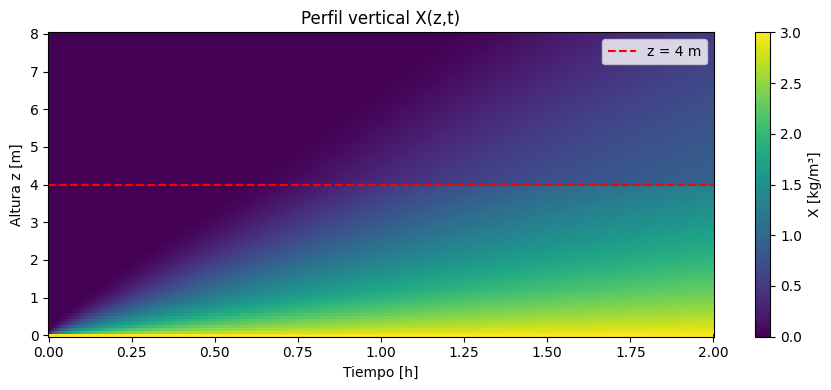

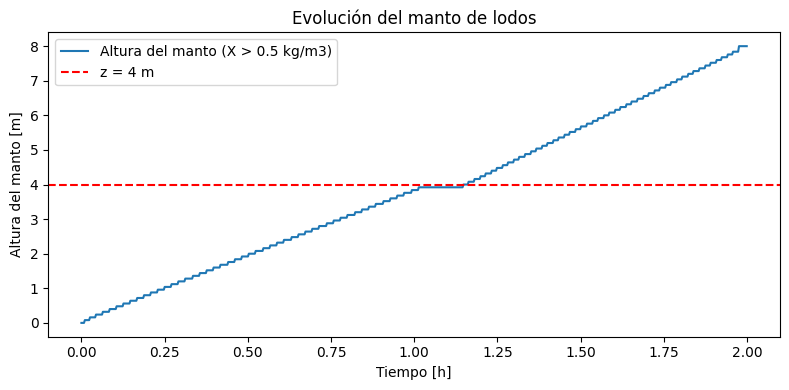

In [1]:
#Modelo Continuo de Sedimentación

import numpy as np                # Importamos las bibliotecas matematicas
import matplotlib.pyplot as plt   # Importamos las bibliotecas para los gráficos

# Modelo de 1D Sedimentador implementado (despreciando la difusion = 0)
#   ∂X/∂t + ∂J_total/∂z = 0
#   J_total = v_bulk(z)*X + X * v0 * exp(-k*X)

# Unidades:
#   z en [m] Altura
#   t en [s] Tiempo
#   Q en [m3/s] Caudales
#   v_bulk, v0 en [m/s] Velocidad vertical
#   X en [kg/m3]  Concentración de solidos

# Parámetros geométricos y de caudal mencionados en una vitacora entregada por EAPSA

A   = 64.6      # [m2] área del sedimentador
H   = 8.0       # [m] altura total del decantador
u   = 1.2       # [-] corrección por floculante

# Caudal total planta: 216 m3/h -> por decantador: 54 m3/h
Q_total_h = 216.0             # [m3/h] Caudal total que pasa de los reactores a los decantadores
Q_in_h    = Q_total_h / 4     # [m3/h] por decantador (Q_total dividido en el número de decantadores)
Q_in      = Q_in_h / 3600.0   # [m3/s] Caudal pasado de m3/h a m3/s

# 20% recircula, 80% sale
frac_r = 0.20                 # Flujo que recircula
Q_r    = frac_r * Q_in        # [m3/s] recirculación
Q_e    = Q_in - Q_r           # [m3/s] efluente

print(f"Q_in = {Q_in:.4f} m3/s, Q_r = {Q_r:.4f} m3/s, Q_e = {Q_e:.4f} m3/s")

# Parámetros de Vesilind (ajustables)
v0 = 0.0015     # [m/s] velocidad máx. de sedimentación (ajústala)
k  = 0.3        # [m3/kg] parámetro de compactación

# Concentración de entrada en el fondo
X_in = 3.0      # [kg/m3]
X_max = 5.0     # [kg/m3] límite físico

# 2. Mallado espacio–tiempo
Nz = 101
z  = np.linspace(0.0, H, Nz)   # 0 = fondo, H = superficie
dz = z[1] - z[0]
print(f"dz = {dz:.3f} m")

# Altura donde cambia de zona espesamiento/clarificación
z_split = H / 2.0              # [m]

#Definimos la función de la velocidad vertical
def v_bulk_z(z_array):
    """
    Velocidad vertical por tramos (m/s):
    - z < z_split  : zona de espesamiento (flujo descendente, negativo)
    - z >= z_split : zona de clarificación (flujo ascendente, positivo)
    """
    v_array = np.zeros_like(z_array)
    v_array[z_array <  z_split] = (- Q_r / A) * u   # descendente
    v_array[z_array >= z_split] = (+ Q_e / A) * u   # ascendente
    return v_array

v_values = v_bulk_z(z)
print(f"v_bulk min = {np.min(v_values):.2e} m/s, max = {np.max(v_values):.2e} m/s")

# Condición CFL  (Courant-Friedrichs-Lewy) para elegir dt
c_max = np.max(np.abs(v_values)) + abs(v0)
CFL   = 0.2
dt    = CFL * dz / c_max        # [s]
print(f"dt = {dt:.2f} s")

t_final = 7200.0                # [s] tiempo total (2 h)
Nt      = int(t_final / dt) + 1
t       = np.linspace(0.0, dt*(Nt-1), Nt)
print(f"Nt = {Nt}, t_final ≈ {t[-1]/3600:.2f} h")

# Definimos el flujo total de sólidos en el decantador

def J_total(X_layer, z_array): #donde v_bulk es el arrastre hidraulico y
                               # X*v0*exp(-k*X) es la sedimentación dependiente de la concentración

    """
    J_total(X,z) = v_bulk(z)*X + X*v0*exp(-k*X)
    Retorna flujo en [kg/(m2·s)]
    """
    v_loc = v_bulk_z(z_array)
    return v_loc * X_layer + X_layer * v0 * np.exp(-k * X_layer)

# Altura del manto de lodos
X_crit = 0.5   # [kg/m3] umbral para decir "hay manto"

def altura_manto_inst(X_profile, z_array, X_crit):
    """
    Devuelve la altura (desde el fondo) hasta donde X > X_crit.
    Si no hay sólidos significativos, retorna 0.
    """
    idx = np.where(X_profile > X_crit)[0]
    if len(idx) == 0:
        return 0.0
    return z_array[idx[-1]]

# Ajustes en la concentración de solidos entorno al tiempo y una altura X(t,z) --> Solución

X = np.zeros((Nt, Nz))   # condición inicial: sin lodos
altura_manto = np.zeros(Nt)

altura_manto[0] = altura_manto_inst(X[0, :], z, X_crit)

# Realizamos el bucle temporal (esquema conservativo explícito)

for n in range(Nt - 1):
    # Borde inferior (z=0): concentración fija X_in
    X[n, 0] = X_in

    # Flujo de sólidos en todos los nodos para el tiempo n
    Jc = J_total(X[n, :], z)

    # Ecuación de conservación:
    # X_i^{n+1} = X_i^n - (dt/dz) * (J_i - J_{i-1})
    X[n + 1, 1:-1] = (
        X[n, 1:-1]
        - (dt / dz) * (Jc[1:-1] - Jc[0:-2])
    )

    # Borde superior (z = H): gradiente nulo (Neumann)
    X[n + 1, -1] = X[n + 1, -2]

    # Limitar a rango físico
    X[n + 1, :] = np.clip(X[n + 1, :], 0.0, X_max)

    # Altura del manto en el nuevo tiempo
    altura_manto[n + 1] = altura_manto_inst(X[n + 1, :], z, X_crit)

# Momento exacto donde el manto llega a los 4 m
altura_objetivo = 4.0   # [m]
indices = np.where(altura_manto >= altura_objetivo)[0]

if len(indices) > 0:
    n_cross = indices[0]
    t_cross = t[n_cross]          # [s]
    hora   = t_cross / 3600.0     # [h]
    mins   = t_cross / 60.0       # [min]

    # Nodo de malla más cercano a z = 4 m
    idx_z4 = np.argmin(np.abs(z - altura_objetivo))
    X_4m   = X[n_cross, idx_z4]

    print(f"\nEl manto alcanza ≈ {altura_objetivo} m en t = {t_cross:.1f} s "
          f"(≈ {hora:.2f} h, {mins:.1f} min).")
    print(f"En z = 4 m, la concentración de sólidos es X ≈ {X_4m:.2f} kg/m3.")
else:
    print(f"\nEn {t_final/3600:.2f} h de simulación el manto nunca llega a {altura_objetivo} m.")


# Se realizan las gráficas necesarias con relación a X(z,t)

# Gráfica del Perfil Vertical X(z,t)
T, Z = np.meshgrid(t/3600.0, z, indexing='ij')  # tiempo en horas para el eje x
plt.figure(figsize=(9, 4))
m = plt.pcolormesh(T, Z, X, shading='auto')
plt.xlabel('Tiempo [h]')
plt.ylabel('Altura z [m]')
plt.title('Perfil vertical X(z,t)')
plt.axhline(altura_objetivo, color='red', linestyle='--', label='z = 4 m')
plt.colorbar(m, label='X [kg/m³]')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Gráfico de altura del manto vs tiempo
plt.figure(figsize=(8, 4))
plt.plot(t/3600.0, altura_manto, label='Altura del manto (X > 0.5 kg/m3)')
plt.axhline(altura_objetivo, color='red', linestyle='--', label='z = 4 m')
plt.xlabel('Tiempo [h]')
plt.ylabel('Altura del manto [m]')
plt.title('Evolución del manto de lodos')
plt.legend()
plt.tight_layout()
plt.show()
